Integrating sphere
==================

For some experiments it may be sufficient to use a standard computer monitor to administer light stimuli, but where research calls for advanced control over the geometry of retinal stimulation, a bespoke setup is required. One solution is to use a Maxwellian view pupillometry system, where the light stimulus is focused onto an aperture positioned in front of the eye, or in the entrance plane of a pharmacologically dilated pupil, and the consensual pupil response is measured from the other eye. But this approach requires some fairly complicated optical engineering and resources that may not be available in the average research setting. As an alternative, we developed a low-cost integrating sphere that provides a full-field, 'Ganzfeld', stimulus and precludes the need for optical engineering, pharmacological dilation of the pupil, or strict fixation control on the part of the participant.

Construction
------------

We built our sphere from two 45 cm flanged acrylic half domes ([Project Plastics Ltd](https://www.projectplastics.co.uk/)), each coated on the inside surface with [Avian-B white reflectance coating](https://aviantechnologies.com/product/avian-b-white-reflectance-coating/) to scatter light homogenously. A 28 cm opening in one of the domes serves as a viewing port and an additional 7 cm (subtending ~9 degrees from the plane of the viewing port) opening opposite the viewing port was included to allow for secondary stimuli (e.g., a fixation target) or to allow for exclusion of the foveal macular pigment from stimulation. On the same half of the sphere as the viewing port, a 30 mm entry port for the light source was cut at an angle of 22.5 deg from the top, such that it could not be seen directly when looking straight ahead. The sphere was stabilised on wooden fixing plate, making it suitable for placement on a desk.

When fully assembled, our setup looks like this:

<img src="../img/setup.JPG" alt="Integrating sphere" title="Integrating sphere" width="500"/>

Calibration
-----------

We need a calibrated forward model that is representative of what an observer actually sees when looking into the sphere, which means we can not rely on STLABs internal spectrometer and must instead collect measurements with an external spectrometer positioned at the plane of the viewing port. `pyplr.calibrate` simplifies this with a `SpectraTuneLabSampler` class, which is just a sub-class of `pyplr.stlab.SpectraTuneLab` with added sampling methods and support for an external spectrometer. Any spectrometer with a python interface can be easily integrated here, but we used an [Ocean Optics STS-VIS](https://www.oceaninsight.com/products/spectrometers/microspectrometer/sts-series/sts-vis/), which is supported by `pyplr.oceanops` and the [Seabreeze](https://pypi.org/project/seabreeze/) Python library. 

It would take a long time to sample every possible device setting, so we opted to sample the full range of intensities in steps of 63 for each LED. 

```Python
from pyplr.calibrate import SpectraTuneLabSampler
from pyplr.oceanops import OceanOptics

oo = OceanOptics.from_first_available()
d = SpectraTuneLabSampler(password='83e47941d9e930f6', external=oo)

# specify leds and intensities to sample
leds = [0,1,2,3,4,5,6,7,8,9]
intensities = [i for i in range(0, 4096, 65)]

# sample
d.sample(leds=leds, 
         intensities=intensities, 
         external=oo,
         randomise=True)
d.make_dfs(save_csv=True)
```

The above code instructs STLAB to cycle through all of the specified settings and obtain measurements with the on-board spectrometer and external spectrometer, if specified. The data are then saved to CSV format in the current working directory. 

Calibrating the OceanOptics data requires some involvement, and was complicated mainly by the fact that we had to account for the effect of PCB temperature and integration time on the raw data. This is how the pipeline looks.

In [ ]:
import sys
sys.path.insert(0, '../')

In [6]:
import pandas as pd

from pyplr.oceanops import predict_dark_counts, calibrated_radiance

# load Ocean Optics data
oo_spectra_fname = '../data/S1_oo_led_intensity_spectra.csv'
oo_info_fname = '../data/S1_oo_led_intensity_info.csv'
oo_spectra = pd.read_csv(oo_spectra_fname, index_col=['led','intensity'])
oo_spectra.reset_index(drop=True, inplace=True)
oo_info = pd.read_csv(oo_info_fname)

# load a file with parameters accounting for the relationship 
# between temperature and integration time. This was created by
# sampling the dark spectrum across a range of integration times
# and temperatures and fitting the data in MATLAB.
darkcal = pd.read_table(
    '../data/oo_dark_cal.txt', skiprows=2, index_col=False)

# predict the dark spectrum for the temperatures and
# integration times of our measurements
oo_dark_counts = predict_dark_counts(oo_info, darkcal)

# load some spectrometer constants
cal_per_wl = pd.read_csv('../data/oo_calibration.csv', header=None)
sensor_area_cm2 = pd.read_csv('../data/oo_sensorArea.csv', header=None)

# calculate calibrated radiance
w_m2_nm = calibrated_radiance(
    oo_spectra, 
    oo_info, 
    oo_dark_counts,
    cal_per_wl, 
    sensor_area_cm2)

# clean up
w_m2_nm['led'] = oo_info['led']
w_m2_nm['intensity'] = oo_info['intensity']
w_m2_nm.set_index(['led', 'intensity'], inplace=True)
w_m2_nm.sort_index(inplace=True)
w_m2_nm = w_m2_nm.interpolate(axis=1)
w_m2_nm.to_csv('../data/S1_corrected_oo_spectra.csv')
w_m2_nm

380       381       382       383       384       385  \
led intensity                                                               
0   0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    65         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    130        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    195        0.000000  0.000000  0.000004  0.000000  0.000010  0.000016   
    260        0.000120  0.000078  0.000143  0.000142  0.000143  0.000136   
...                 ...       ...       ...       ...       ...       ...   
9   3835       0.004805  0.004619  0.004544  0.004574  0.004250  0.003880   
    3900       0.004468  0.004790  0.004257  0.004693  0.003956  0.003621   
    3965       0.004797  0.005050  0.004623  0.004957  0.004305  0.004161   
    4030       0.004834  0.005387  0.004674  0.005162  0.004448  0.004247   
    4095       0.005099  0.005310  0.005037  0.005156  0.004420  0.004231   

                    386       387       388       389  ...       771  \
led intensity                                          ...             
0   0          0.000000  0.000000  0.000000  0.000000  ...  0.000000   
    65         0.000000  0.000000  0.000000  0.000000  ...  0.000000   
    130        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
    195        0.000002  0.000032  0.000013  0.000015  ...  0.000002   
    260        0.000148  0.000136  0.000151  0.000161  ...  0.000067   
...                 ...       ...       ...       ...  ...       ...   
9   3835       0.004228  0.003484  0.003731  0.004273  ...  0.002943   
    3900       0.004206  0.003458  0.003854  0.004562  ...  0.002951   
    3965       0.004243  0.003879  0.003819  0.004699  ...  0.003149   
    4030       0.004708  0.004041  0.004074  0.005171  ...  0.003273   
    4095       0.004623  0.004095  0.004487  0.004984  ...  0.003231   

                    772       773       774       775       776           777  \
led intensity                                                                   
0   0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00   
    65         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00   
    130        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00   
    195        0.000000  0.000000  0.000000  0.000000  0.000003  5.243781e-07   
    260        0.000062  0.000076  0.000079  0.000058  0.000078  6.537223e-05   
...                 ...       ...       ...       ...       ...           ...   
9   3835       0.003430  0.003303  0.003304  0.003584  0.003266  3.256202e-03   
    3900       0.003260  0.003288  0.003022  0.003308  0.003081  3.191800e-03   
    3965       0.003538  0.003434  0.003165  0.003345  0.003596  3.275223e-03   
    4030       0.003528  0.003760  0.003473  0.003938  0.003540  3.482008e-03   
    4095       0.003729  0.003792  0.003311  0.003832  0.003505  3.427454e-03   

                    778       779       780  
led intensity                                
0   0          0.000000  0.000000  0.000000  
    65         0.000000  0.000000  0.000000  
    130        0.000000  0.000000  0.000000  
    195        0.000000  0.000009  0.000000  
    260        0.000000  0.000086  0.000082  
...                 ...       ...       ...  
9   3835       0.002860  0.003361  0.003514  
    3900       0.002890  0.003207  0.003290  
    3965       0.002831  0.003219  0.003477  
    4030       0.003338  0.003347  0.003911  
    4095       0.003110  0.003654  0.003819  

[640 rows x 401 columns]

Now we have our calibrated data from the external spectrometer, we can use `pyplr.calibrate.CalibrationContext(...)` to interpolate the rest of the settings and create a forward model for our STLAB-sphere rig.

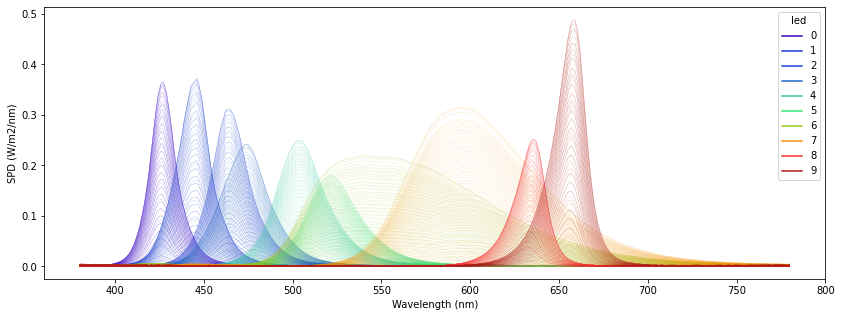

In [5]:
from pyplr.calibrate import CalibrationContext

cc = CalibrationContext(
    '../data/S1_corrected_oo_spectra.csv', binwidth=1)
fig = cc.plot_calibrated_spectra()

The calibration context gives quick and easy access to the raw data, interpolated data, lux, aopic, etc., and it allows us to predict a spectrum based on the input values of STLAB. 

Safety
------

We want to be sure that we are not subjecting our research participants to dangerous levels of light. 